##               COMP47670 Assignment 2: Text Classification

### Name: Keerthi Prasad Ganganna
### Student ID: 18200322

In [1]:
# import neccessary libraries
import re
import pandas as pd
import requests
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn import svm
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

base_url="http://mlg.ucd.ie/modules/yalp/"

#nltk.download('wordnet')

### Task1 : Select two review categories of your choice. Scrape all reviews for each category and store them as two separate datasets. 


In [2]:
# Get links of categories of reviews
def get_category_links(base_url):
    req = requests.get(base_url)

    soup = BeautifulSoup(req.content, 'html.parser')

    links = []
    for link in soup.findAll('a'):
        links.append(base_url+link.get('href'))
    return links

#get links of review list pages
def get_category_pages(links,choice):
    pages=[]
    link=links[choice]
    page = requests.get(link)
    soup = BeautifulSoup(page.content, 'html.parser')
    pages.append(soup)
    return pages 

#get list of review pages
def get_review_pages(pages):
    review_pages=[]
    soup=pages
    
    for link in soup[0].findAll('a'):
        review_pages.append(base_url+link.get('href'))
    return review_pages

    
#get each review and extract rating stars and review text
def read_ratings_and_reviews(review_pages):
    df_final=pd.DataFrame(columns=['reviews', 'ratings'])
    ratings=[]
    reviews=[]
    for x in review_pages:
        ratings=[]
        reviews=[]
        try:
            req = requests.get(x)
            soup = BeautifulSoup(req.content, 'html.parser')
        except:
            print("error connecting")
       
        images=soup.find_all('img')
        #print([i['src'] for i in images])

        for im in images:
            rval=(im['src'][-5])
            ratings.append(rval)
            
        ratings=ratings[1:]        
        rvt=soup.find_all('p',{'class':'text'})
        
        for rv in rvt:
            reviews.append(rv.text)
            
        df=pd.DataFrame({'reviews':reviews,'ratings':ratings})
        df_final=df_final.append(df)
        #print(df)
    df_final=df_final.append(df,ignore_index=True)
    return df_final
    

In [3]:
# A function to call the scraping functions in order and store it in csv
#Input is a fiename to store the data and choice integer
#0-Automotive 1-Bars 2-health and medical 3-Hotel and travel 4-restaurants
def collect_data(choice,filename):
    base_url="http://mlg.ucd.ie/modules/yalp/"
    links=get_category_links(base_url) 
    pages=get_category_pages(links,choice) 
    review_pages= get_review_pages(pages) 
    
    #storing positive ratings as 1 and negative as 0
    read_data=read_ratings_and_reviews(review_pages) 
    read_data['ratings'] = read_data['ratings'].astype('float64') 
    read_data['ratings']=read_data['ratings'].apply(lambda s:  1 if s>3 else 0 )
    read_data.to_csv(filename,index=False)
       
    
#A function to remove stop words  
def remove_stop_words(data):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    data['reviews']=data['reviews'].apply(lambda s:  pattern.sub('', s) if len(s)>0 else s ) 
    return data

#A function to remove special characters and numbers
def remove_numeric_special(data):
    data['reviews']=data['reviews'].apply(lambda s:  re.sub('[^A-Za-z]+', ' ', s)  if len(s)>0 else s ) 
    return data 

#lemmatizing all the words
def lemmatize(data):
    lemmatizer = WordNetLemmatizer()       
    data['reviews'] = data['reviews'].apply(lambda x: ''.join([lemmatizer.lemmatize(i) for i in x])) 
    return data

In [4]:
#collect data from category automobile and bars
#Input is a fiename to store the data and choice integer
#0-Automotive 1-Bars 2-health and medical 3-Hotel and travel 4-restaurants
#I have chosen Automotive and bars for demonstration
collect_data(0,'automobile.csv')
collect_data(1,'bars.csv')


#read the data which was scraped and stored in the  csv files
automobile_data=pd.read_csv('automobile.csv')
bars_data=pd.read_csv('bars.csv') 

print("automotive dataframe \n",automobile_data.head(10),'\n\n') 

print("bars dataframe \n",bars_data.head(10)) 


automotive dataframe 
                                              reviews  ratings
0  I arrived at 3 PM and the dealership closed at...        1
1  I dropped my car off on a Wednesday morning fo...        0
2  My parents have been buying cars off of Donna ...        1
3  I recently bought another car from Donna Dunni...        1
4  I had to schedule an appointment due to the ai...        1
5  Leslie, Your and your team should review my co...        0
6  We called to ask if they had any red Escalades...        0
7  Update on my review. Scott the initial salespe...        1
8  If you're planning on buying a Cadillac, See L...        1
9  Such a great experience! The staff were very n...        1 


bars dataframe 
                                              reviews  ratings
0  It would help if the front girl don't just sit...        0
1  One star because that's the least amount you c...        0
2  Bad time today. Dirty windows, table sticky, h...        0
3  My second visit in the l

## Task2

### 1. convert data into numerical representsion suitable for classifcation

### 2. Build a classsification model to classify positive or negative review

### 3. Test the predictions using appropriate evaluation strategy


In [5]:

#combine the two datasets  for preprocessing
combined_data=automobile_data.append(bars_data)

#remove numeric and special characters
combined_data=remove_numeric_special(combined_data)

#remove stop words
combined_data=remove_stop_words(combined_data)

#lemmatize the given data
combined_data=lemmatize(combined_data)

In [6]:
# convert the text data into sparse matrix which is fed to machine learning model
vectorizer = CountVectorizer() 
corpus = combined_data['reviews']
X = vectorizer.fit_transform(corpus)
new_x_data=X[ :len(combined_data):]

In [8]:
# divide the data back to its original dimensions i.e seperate  combined data into its respective category
auto_data=new_x_data[:len(automobile_data)]
bar_data=new_x_data[len(automobile_data):]

In [9]:
#split the automotive review data into training and testing
X_train_auto, X_test_auto, y_train_auto, y_test_auto = train_test_split(  auto_data, automobile_data['ratings'], test_size=0.33, random_state=42)

In [10]:
#Create a randomforest classifier

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [30,40,50],
    'n_estimators': [100, 200, 300, 500]
}

rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train_auto, y_train_auto) 
randomforestmodel = grid_search.best_estimator_

 
#train the model with train set
randomforestmodel.fit(X_train_auto, y_train_auto) 

#predict the model using test set
y_pred = randomforestmodel.predict(X_test_auto)

#measure accuracy
auto_acc=accuracy_score(y_test_auto, y_pred)
print("Accuracy score of Random Forest classifier for automotive review data is ", auto_acc)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   25.9s finished


Accuracy score of Random Forest classifier for automotive review data is  0.8405797101449275


In [11]:
print(metrics.classification_report(y_test_auto, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(y_test_auto), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       0.91      0.56      0.69       155
           1       0.82      0.97      0.89       328

   micro avg       0.84      0.84      0.84       483
   macro avg       0.87      0.77      0.79       483
weighted avg       0.85      0.84      0.83       483

Confusion Matrix


Predicted,0,1,All
True,,,
0,87,68,155
1,9,319,328
All,96,387,483


In [12]:

#split the bar review data into train and split
X_train_bar, X_test_bar, y_train_bar, y_test_bar = train_test_split(  bar_data, bars_data['ratings'], test_size=0.33, random_state=42)

In [13]:
#Create a svm Classifier
svmclassifier = svm.SVC(kernel='linear') 

#Train the model using the training sets
svmclassifier.fit(X_train_bar, y_train_bar)

#Predict the response for test dataset
y_pred = svmclassifier.predict(X_test_bar)

bar_acc=accuracy_score(y_test_bar, y_pred)
print("Accuracy score of SVM classifier for bars review data is ", bar_acc)

Accuracy score of SVM classifier for bars review data is  0.8475609756097561


In [14]:
print(metrics.classification_report(y_test_bar, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(y_test_bar), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       185
           1       0.88      0.88      0.88       307

   micro avg       0.85      0.85      0.85       492
   macro avg       0.84      0.84      0.84       492
weighted avg       0.85      0.85      0.85       492

Confusion Matrix


Predicted,0,1,All
True,,,
0,147,38,185
1,37,270,307
All,184,308,492


# Task 3

### 1. Train a classification model on the data from “Category A”, and evaluate its performance on the data from “Category B”.
### 2. Train a classification model on the data from “Category B”, and evaluate its performance on the data from “Category A”.



 In this experiment, I have built an SVM classifier and trained it on bars data. I will predict the automotive review data with this model and check for the accuracy_score and f-1 score

In [15]:
# predict the automotive data on model which was trained on bars data
y_pred = svmclassifier.predict(X_test_auto)
accuracy_score(y_test_auto, y_pred)

0.7660455486542443

In [16]:
print(metrics.classification_report(y_test_auto, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(y_test_auto), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       0.60      0.85      0.70       155
           1       0.91      0.73      0.81       328

   micro avg       0.77      0.77      0.77       483
   macro avg       0.75      0.79      0.75       483
weighted avg       0.81      0.77      0.77       483

Confusion Matrix


Predicted,0,1,All
True,,,
0,131,24,155
1,89,239,328
All,220,263,483


 In this experiment, I have built a randomforest classifier and trained it on automotive data. I will predict the bars review data with this model and check for the accuracy_score and f-1 score


In [17]:
# predict the automotive data on model which was trained on bars data
y_pred = randomforestmodel.predict(X_test_bar)
accuracy_score(y_test_bar, y_pred)

0.7215447154471545

In [18]:
print(metrics.classification_report(y_test_bar, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(y_test_bar), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       0.86      0.31      0.45       185
           1       0.70      0.97      0.81       307

   micro avg       0.72      0.72      0.72       492
   macro avg       0.78      0.64      0.63       492
weighted avg       0.76      0.72      0.68       492

Confusion Matrix


Predicted,0,1,All
True,,,
0,57,128,185
1,9,298,307
All,66,426,492


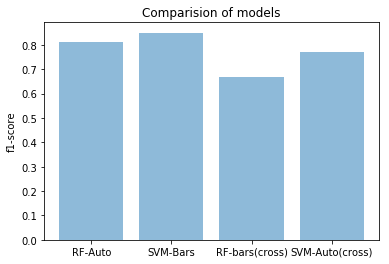

In [19]:

objects = ('RF-Auto', 'SVM-Bars' ,'RF-bars(cross)', 'SVM-Auto(cross)')
y_pos = np.arange(len(objects))
performance = [0.81, 0.85 ,0.67,0.77 ]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects) 
plt.ylabel('f1-score')
plt.title('Comparision of models') 



plt.show()

## Summary

I scraped the review text and ratings of automotive and bars reviews using beautiful soup, and stored the results in a dataframe. reviews with 4 and 5 stars are considered postive and the remaining are negative, which is represented by 1 and 0 respectively.

After removing all numerical and special characters. Stop words are removed, and the text is lemmatized.

I converted the text data into sparse matrix using CountVectrorizer. Now both train data and label are in numerical form, ready to be fed to machine learning algorithms.

I used a randomforest classifier with gridCV search for tuning parameters, with the best model, I trained automotive review data, and tested with the test data to get an f1-score of 0.81.

I used an SVM classifier, I trained bars review data, and tested with the test data to get an f1-score of 0.85.

In first experiment, I tested the bars data on Randomforestclassifier trained on automotive data, f1-score obtained was 0.67.

In second experiment, I tested the automotive data on SVM classifier trained on bars data, f1-score obtained was 0.77.


## Conclusion

Text classification tasks require a good amount of pre-processing, to make the data fit for using them in machine learning models.

Models perform well on the test data from the same data source. Performance after category swap decreases, but still good enough.